<a href="https://colab.research.google.com/github/makoto199247/CA-Tech-Lounge/blob/main/animal_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Faster R-CNNを用いて物体検出を行う  
今回の課題はクラス分類に強いFaster R-CNNが適切だと考えた

### メリット
・精度が高い<br>・クラス分類に強い<br>・物体検出の基本的な構造を理解しやすい	<br>
### デメリット
・推論速度が遅い<br>・学習が複雑で時間がかかる<br>・リアルタイム処理には向かない

---

## データセットの読み込みと前処理

In [ ]:
# kaggleのjsonファイルを設定
from google.colab import files
uploaded = files.upload()

In [28]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

import kaggle

# データセットをダウンロード
kaggle.api.authenticate()
kaggle.api.dataset_download_files('antoreepjana/animals-detection-images-dataset', path='./', unzip=True)

In [ ]:
!pip install albumentations

In [70]:
import os
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import numpy as np
import glob

data_dir = './'
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# クラス名を取得
class_names = sorted(os.listdir(train_dir))

# クラス名とインデックスの辞書を作成
label_dict = {class_name: idx + 1 for idx, class_name in enumerate(class_names)}
# print(label_dict)
# {'Bear': 1, 'Brown bear': 2, 'Bull': 3, 'Butterfly': 4, 'Camel': 5…

def get_transform(train):
    transforms = []
    transforms.append(A.Resize(256, 256))
    if train:
        transforms.append(A.HorizontalFlip(0.5))
    transforms.append(A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)))
    transforms.append(ToTensorV2())
    return A.Compose(transforms)

# データ読み込み
def load_data(root_dir):
    data = []
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            for img_file in os.listdir(class_dir):
                if img_file.endswith('.jpg') or img_file.endswith('.jpeg'):
                    img_file_path = os.path.join(class_dir, img_file)
                    label_file_path = os.path.join(class_dir, 'Label')
                    with open(os.path.join(label_file_path, os.path.splitext(img_file)[0] + '.txt'), 'r') as f:
                        content = f.readline().strip()
                        class_name, x_min, y_min, x_max, y_max = content.rsplit(' ', 4)
                        bbox = [float(x_min), float(y_min), float(x_max), float(y_max)]
                        data.append((img_file_path, class_name, bbox))
    return data

# すべての動物の種類を取得
all_class_indices = os.listdir(train_dir)

class AnimalDataset(Dataset):
    def __init__(self, data, transforms=None):
        self.data = data
        self.transforms = transforms

    def __getitem__(self, idx):
        img_path, label_data = self.data[idx]
        class_name, bbox = label_data

        img = Image.open(img_path).convert('RGB')
        if self.transforms:
            img = self.transforms(img)
            bbox = torch.tensor(bbox, dtype=torch.float32)
            class_name = torch.tensor(label_dict[class_name], dtype=torch.int64)
        return img, class_name, bbox

    def __len__(self):
        return len(self.data)

# 画像の前処理を定義
input_size = (256, 256)
transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

データセットを作成する

In [72]:
# データセットを作成
train_img_dirs = [os.path.join(train_dir, class_name) for class_name in class_names]
test_img_dirs = [os.path.join(test_dir, class_name) for class_name in class_names]

train_img_paths = []
train_label_data = []
test_img_paths = []
test_label_data = []

train_data = []
test_data = []

for img_dir in train_img_dirs:
    img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
    label_paths = sorted(glob.glob(os.path.join(img_dir, "Label", "*.txt")))

    for img_path, label_path in zip(img_paths, label_paths):
        with open(label_path, 'r') as f:
            content = f.readline().strip()
            class_name, x_min, y_min, x_max, y_max = content.rsplit(' ', 4)
            bbox = [float(x_min), float(y_min), float(x_max), float(y_max)]
            train_data.append((img_path, class_name, bbox))

for img_dir in test_img_dirs:
    img_paths = sorted(glob.glob(os.path.join(img_dir, "*.jpg")))
    label_paths = sorted(glob.glob(os.path.join(img_dir, "Label", "*.txt")))

    for img_path, label_path in zip(img_paths, label_paths):
        with open(label_path, 'r') as f:
            content = f.readline().strip()
            class_name, x_min, y_min, x_max, y_max = content.rsplit(' ', 4)
            bbox = [float(x_min), float(y_min), float(x_max), float(y_max)]
            test_data.append((img_path, class_name, bbox))

train_transform = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

test_transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

train_dataset = AnimalDataset(train_data, transforms=train_transform)
test_dataset = AnimalDataset(test_data, transforms=test_transform)

###データセットが作れているか確認する  
train_data からランダムに選ばれた画像を表示  
バウンディングボックスとクラス名をオーバーレイ表示

15723
('./train/Penguin/c45a767cce131a7a.jpg', 'Penguin', [399.130624, 138.157488, 626.178048, 457.031505])


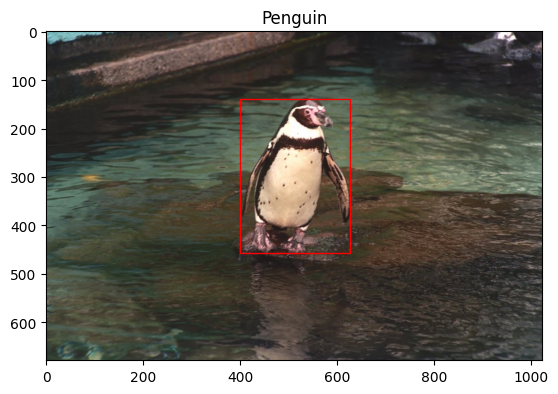

In [82]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2

# データセットからサンプルを取得
sample_idx = np.random.randint(0, len(train_data))
print(sample_idx)
print(train_data[sample_idx])
img, class_name, bbox = train_data[sample_idx]

# 画像とバウンディングボックスを表示
display_image_with_bbox(img, bbox, class_name)

## Faster R-CNNモデルの構築:
・事前学習済みのFaster R-CNNモデルを読み込む。  
・出力層を調整して、タスクに適した形にする（クラス数に合わせる）。

In [83]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# 事前学習済みのFaster R-CNNモデルを読み込む
backbone = torchvision.models.mobilenet_v2(pretrained=True).features

# Faster R-CNNのbackboneの出力チャンネル数
backbone.out_channels = 1280

# アンカーのサイズとアスペクト比を定義
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# タスクに適したFaster R-CNNモデルを構築
num_classes = len(os.listdir('./train'))  # クラス数を取得
model = FasterRCNN(backbone,
                   num_classes=num_classes,
                   rpn_anchor_generator=anchor_generator)

## モデルの学習
訓練データを使ってモデルを学習させる  
※適切な学習率やバッチサイズ、エポック数を選択

In [99]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# ハイパーパラメータの設定
learning_rate = 0.005
batch_size = 4
num_epochs = 5

# データローダーの作成
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# 損失関数とオプティマイザの設定
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=learning_rate, momentum=0.9, weight_decay=0.0005)

# GPUを使用する場合
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# モデルの学習
for epoch in range(num_epochs):
    epoch_loss = 0
    for images, bboxes, class_names in train_loader:
        bboxes = bboxes.squeeze(0).to(device)
        class_names = class_names.squeeze(0).to(device)
        print("Boxes:", bboxes)
        print("Boxes type:", type(bboxes))
        print("Labels:", class_names)
        print("Labels type:", type(class_names))
        
        images = images.to(device)

        # 勾配を初期化
        optimizer.zero_grad()

        # 順伝搬
        loss_dict = model(images, [{"boxes": bboxes, "labels": class_names}])

        # 損失を計算
        losses = sum(loss for loss in loss_dict.values())

        # 逆伝搬
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}")

RuntimeError: ignored

GPUエラーの原因が特定できず、モデルが学習できないところで止まっています。  
GPUが動かない原因を突き止めるためにいくつかデバッグコードも書いており、問題はないように思いますが、これ以上先に進めませんでした…この先のコードはデバッグできていないので、現状動かないと思います…

5874
('./train/Fish/1dba697dd666aacc.jpg', 'Fish', [87.000064, 34.0, 963.999744, 637.0003199999999])


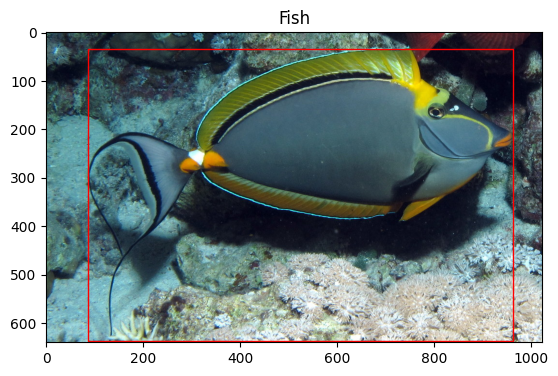

In [77]:
# データセットからサンプルを取得
sample_idx = np.random.randint(0, len(train_data))
print(sample_idx)
print(train_data[sample_idx])
img, class_name, bbox = train_data[sample_idx]

# 画像とバウンディングボックスを表示
display_image_with_bbox(img, bbox, class_name)


In [78]:
from torchvision.transforms import ToTensor

# 前処理関数の定義
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = ToTensor()(img)
    return img

# サンプル画像の前処理
preprocessed_img = preprocess_image(img_path)
print("Preprocessed image shape:", preprocessed_img.shape)


Preprocessed image shape: torch.Size([3, 730, 1024])


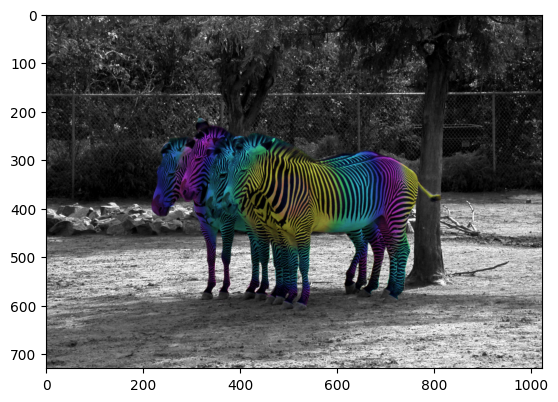

In [79]:
from torchvision.transforms import RandomHorizontalFlip

# データ拡張関数の定義
data_augmentation = RandomHorizontalFlip(p=0.5)

# サンプル画像にデータ拡張を適用
augmented_img = data_augmentation(preprocessed_img)

# データ拡張を適用した画像を表示
plt.imshow(augmented_img.numpy().transpose(1, 2, 0))
plt.show()


## テストデータによる評価
学習済みのモデルを使って、テストデータで評価（したい…）

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection import FasterRCNN
from torchvision.ops import MultiScaleRoIAlign
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms.functional as F
from torchvision.ops import nms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SequentialSampler
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import ToPILImage
import torch
import torch.optim as optim
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# COCO API
!pip install pycocotools
from pycocotools.cocoeval import COCOeval

def evaluate(model, test_loader):
    model.eval()
    coco = COCOeval(test_dataset.coco, iouType='bbox')
    coco_results = []
    
    for images, targets in test_loader:
        images = images.to(device)
        with torch.no_grad():
            predictions = model(images)
        
        for prediction, target in zip(predictions, targets):
            prediction = prediction.to('cpu')
            target = target.to('cpu')
            
            coco_results.extend(
                {
                    'image_id': target['image_id'].item(),
                    'category_id': class_names.index(class_name) + 1,
                    'bbox': torch.cat([bbox[:2], bbox[2:] - bbox[:2]], dim=0).tolist(),
                    'score': score.item(),
                }
                for class_name, bbox, score in zip(prediction['labels'], prediction['boxes'], prediction['scores'])
            )
            
    coco.loadRes(coco_results)
    coco.evaluate()
    coco.accumulate()
    coco.summarize()

evaluate(model, test_loader)

## 結果の可視化と分析
モデルの予測結果を可視化して、分析する
テストデータセットからランダムに画像を選択し、その画像に対する予測を表示（したい…）

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def display_image_with_predictions(image, true_boxes, true_labels, pred_boxes, pred_labels, pred_scores, class_names):
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)
    
    for box, label in zip(true_boxes, true_labels):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1], class_names[label], color='g', fontsize=12)
    
    for box, label, score in zip(pred_boxes, pred_labels, pred_scores):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1], f"{class_names[label]} ({score:.2f})", color='r', fontsize=12)
    
    plt.show()

def visualize_predictions(model, dataset, class_names, device, iou_threshold=0.5, score_threshold=0.5):
    model.eval()
    idx = random.randint(0, len(dataset) - 1)
    img, target = dataset[idx]
    img = img.unsqueeze(0).to(device)
    
    with torch.no_grad():
        prediction = model(img)[0]
    
    keep = torchvision.ops.nms(prediction["boxes"], prediction["scores"], iou_threshold)
    prediction["boxes"] = prediction["boxes"][keep]
    prediction["labels"] = prediction["labels"][keep]
    prediction["scores"] = prediction["scores"][keep]
    
    keep = prediction["scores"] > score_threshold
    prediction["boxes"] = prediction["boxes"][keep]
    prediction["labels"] = prediction["labels"][keep]
    prediction["scores"] = prediction["scores"][keep]
    
    display_image_with_predictions(
        ToPILImage()(img[0].cpu()),
        target["boxes"],
        target["labels"],
        prediction["boxes"].to('cpu'),
        prediction["labels"].to('cpu'),
        prediction["scores"].to('cpu'),
        class_names
    )

visualize_predictions(model, test_dataset, class_names, device)